Prelude , A Datasaster for Newbie

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this case, I try to generate the analysis of what sorts of people were likely to survive. In particular, to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd
import datetime, pytz
import io
import requests

import seaborn as sb
import matplotlib as mpl

import sklearn

Data Collection

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [4]:
print(test.columns.values)

['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [5]:
# preview training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# preview test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Survived passengers (%) by gender

In [7]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Survived passengers (%) by ticket class

In [8]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Survived passengers (%) by number of siblings/spouses

In [9]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Survived passengers (%) by number of parents/children

In [10]:
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Survived passengers (%) by combination of parents/children and siblings/spouses

In [11]:
train[['SibSp','Parch', 'Survived']].groupby(['Parch','SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,SibSp,Survived
16,3,0,1.000000
3,0,3,1.000000
18,3,2,1.000000
6,1,2,0.857143
9,2,0,0.724138
4,1,0,0.657895
10,2,1,0.631579
5,1,1,0.596491
1,0,1,0.520325
11,2,2,0.500000


Survived passengers (%) by port of embarkation

(C = Cherbourg, Q = Queenstown, S = Southampton)

In [12]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Survived passengers (%) by age

In [13]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

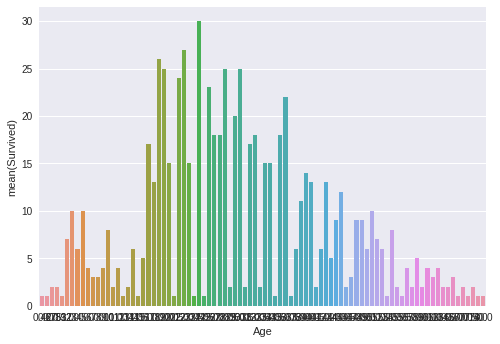

In [14]:
agecount = train[['Age', 'Survived']].groupby(['Age'],as_index=False).count()
sb.barplot(x='Age', y='Survived', data=agecount)